<a href="https://colab.research.google.com/github/Laksh-143/Credit--Card-Fraud-Detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score,accuracy_score

In [2]:
df = pd.read_csv('fraudTrain.csv')
df_test = pd.read_csv('fraudTest.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [6]:
# setting a clean style for plots.
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [7]:
print(df.shape)
print(df_test.shape)

(1296675, 23)
(555719, 23)


Quality checks.

In [8]:
"""
Checking if there exists any missing values in the dataset or not. if there is
then we will try to use different methods like dropping those rows or imputing them.
"""
null_counts1=df.isnull().sum()
if (null_counts1.sum()==0):
    print("No missing values found in training set.")
else:
    print("Missing values found in training set.")

null_counts2=df_test.isnull().sum()
if (null_counts2.sum()==0):
    print("No missing values found in test set.")
else:
    print("Missing values found in test set.")

No missing values found in training set.
No missing values found in test set.


In [9]:
"""
Checking if there exists any duplicates in the dataset or not. if there is then
we will drop them.
"""
duplicates1 = df[df.duplicated(subset=['cc_num', 'amt', 'trans_date_trans_time'])]
if len(duplicates1) == 0:
    print(" No duplicate transactions found in training set.")
else:
    print(f" Found {len(duplicates1)} duplicate rows in training set.")
    df = df.drop_duplicates()

duplicates2 = df_test[df_test.duplicated(subset=['cc_num', 'amt', 'trans_date_trans_time'])]
if len(duplicates2) == 0:
    print(" No duplicate transactions found in test set.")
else:
    print(f" Found {len(duplicates2)} duplicate rows in test set.")
    df_test = df_test.drop_duplicates()

 No duplicate transactions found in training set.
 No duplicate transactions found in test set.


In [10]:
"""
Transaction cannot be negative or zero so we will check for that.
"""
if (df['amt']==0).any():
  print(" there are transaction with zero amount in training set.")
elif (df['amt']<0).any():
  print(" there are transaction with negative ampount in training set.")
else:
  print("All values in amt are validin training set.")

if (df_test['amt']==0).any():
  print(" there are transaction with zero amount in test set.")
elif (df_test['amt']<0).any():
  print(" there are transaction with negative ampount in test set.")
else:
  print("All values in amt are valid in test set.")

All values in amt are validin training set.
All values in amt are valid in test set.


In [11]:
"""
Going through the coordinates to check if they are valid or not.
"""
invalid_lat = df[(df['lat'] < -90) | (df['lat'] > 90)]
print(f"Invalid Latitudes Found: {len(invalid_lat)}")
invalid_long = df[(df['long'] < -180) | (df['long'] > 180)]
print(f"Invalid Longitudes Found: {len(invalid_long)}")

invalid_merch_lat = df[(df['lat'] < -90) | (df['lat'] > 90)]
print(f"Invalid merchant Latitudes Found: {len(invalid_lat)}")
invalid_merch_long = df[(df['long'] < -180) | (df['long'] > 180)]
print(f"Invalid merchant Longitudes Found: {len(invalid_long)}")

Invalid Latitudes Found: 0
Invalid Longitudes Found: 0
Invalid merchant Latitudes Found: 0
Invalid merchant Longitudes Found: 0


Class Imbalanace check

In [12]:

fraud_counts = df['is_fraud'].value_counts()
fraud_counts

,count
is_fraud,
0,1289169
1,7506







**Feature Engineering**

In [13]:
"""
If we feed the model raw numbers like lat = 40.71 and merch_lat = 34.05, the
model sees them as just two random numbers and not location of a particular
point.
We use the haversine formula to calculate the distance between the user and
merchant location.
"""

def haversine_vectorized(lat1, lon1, lat2, lon2):
    # 1. Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # 3. Radius of earth in miles
    r = 3959
    return c * r
df['dist_to_merch'] = haversine_vectorized(
    df['lat'], df['long'],
    df['merch_lat'], df['merch_long']
)
df_test['dist_to_merch'] = haversine_vectorized(
    df_test['lat'],df_test['long'],
    df_test['merch_lat'],df_test['merch_long']
)


In [14]:
'''
the datatype of 'trans_date_trans_time' and 'dob' is object which can be changed to
 date time which is more accurate datatype.
'''

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])
df_test['dob'] = pd.to_datetime(df_test['dob'])

In [15]:
'''
age is an important feature as fraud patterns may vary for different age groups.
And age of person is calculated at the time of transaction.
'''
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
df_test['age'] = (df_test['trans_date_trans_time'] - df_test['dob']).dt.days // 365

In [16]:

"""
Population as normal random integers are not useful. Thus categorizing them into
3 different categories.
"""
def classify_pop(pop):
    if pop < 10000:
        return 'rural'
    elif pop < 100000:
        return 'suburban'
    else:
        return 'urban'
df['pop_type'] = df['city_pop'].apply(classify_pop)
df_test['pop_type'] = df_test['city_pop'].apply(classify_pop)

In [17]:
'''fetching the hour of the transaction, to see in future which hour is most common for fraudsters.'''

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

df_test['hour'] = df_test['trans_date_trans_time'].dt.hour
df_test['day'] = df_test['trans_date_trans_time'].dt.day
df_test['month'] = df_test['trans_date_trans_time'].dt.month

In [18]:
'''
As the amt has high transaction which will be given more importance in model ,
thus using log scale to scale down the big numbers and reduce the gap between them.
'''
df['amt_log'] = np.log1p(df['amt'])
df_test['amt_log'] = np.log1p(df_test['amt'])

'''Checking the frequency of the transactions done by the person in a single day .
  if there are lot of transactions in one day then it is very likely that it is fraud.
  for calculating the frequency we need to sort the rows first as if there are not sorted then it may intrepret wrong.
'''
df = df.sort_values(['cc_num', 'trans_date_trans_time'])
df_test = df_test.sort_values(['cc_num', 'trans_date_trans_time'])
df['daily_trans_count'] = df.groupby(['cc_num', df['trans_date_trans_time'].dt.date]).cumcount() + 1
df_test['daily_trans_count'] = df_test.groupby(['cc_num', df_test['trans_date_trans_time'].dt.date]).cumcount() + 1


In [19]:
"""
 These columns are very not used in the analysis and prediction.
"""
cols_to_drop = ['trans_num', 'first', 'last', 'street', 'unix_time', 'zip', 'Unnamed: 0',
                'lat', 'long', 'merch_lat', 'merch_long','state','city','trans_date_trans_time','dob','cc_num','city_pop']
df_refined = df.drop(columns = cols_to_drop , axis=1)
df_test_refined = df_test.drop(columns = cols_to_drop , axis =1)

In [ ]:
df_refined[df_refined['is_fraud']==1]

,merchant,category,amt,gender,job,is_fraud,dist_to_merch,age,pop_type,hour,amt_log,daily_trans_count
102490,fraud_Marks Inc,gas_transport,13.17,F,Information systems manager,1,29.859064,33,rural,1,2.651127,1
102556,fraud_Cummings LLC,gas_transport,11.74,F,Information systems manager,1,54.804388,33,rural,2,2.544747,2
104145,fraud_Labadie LLC,personal_care,19.16,F,Information systems manager,1,71.449660,33,rural,23,3.003700,3
106627,fraud_Barrows PLC,shopping_pos,830.06,F,Information systems manager,1,50.119680,33,rural,22,6.722702,1
106628,"fraud_Windler, Goodwin and Kovacek",home,261.79,F,Information systems manager,1,59.764660,33,rural,22,5.571355,2
...,...,...,...,...,...,...,...,...,...,...,...,...
713362,"fraud_Schmeler, Bashirian and Price",shopping_net,961.40,M,Audiological scientist,1,46.488420,63,rural,23,6.869430,4
713531,fraud_Rutherford-Mertz,grocery_pos,302.91,M,Audiological scientist,1,69.222675,63,rural,2,5.716732,1
714377,"fraud_Kihn, Abernathy and Douglas",shopping_net,1091.87,M,Audiological scientist,1,65.336484,63,rural,14,6.996563,2
715082,fraud_Hills-Witting,shopping_net,1050.88,M,Audiological scientist,1,72.499905,63,rural,22,6.958334,3


EDA

1. legit vs fraud distribution
*   Distribution to show the percentage of imbalance in the dtaset.




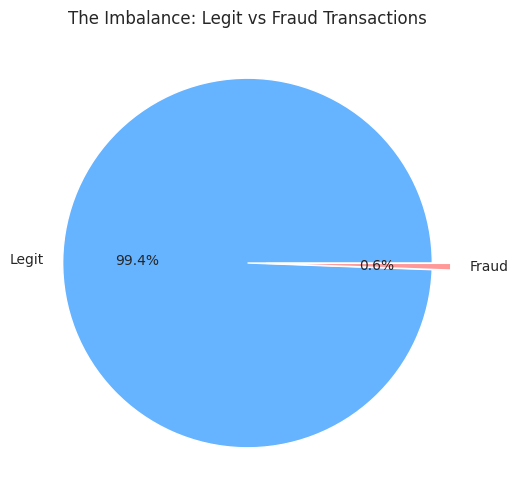

In [20]:
fraud_counts = df_refined['is_fraud'].value_counts()
labels = ['Legit', 'Fraud']

# 2. Plot Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], explode=(0, 0.1))
plt.title('The Imbalance: Legit vs Fraud Transactions')
plt.show()

2. Hour vs Fraud .

*   Distribution to see in which hours the fraud is more likely done or have the high percentage to happen.



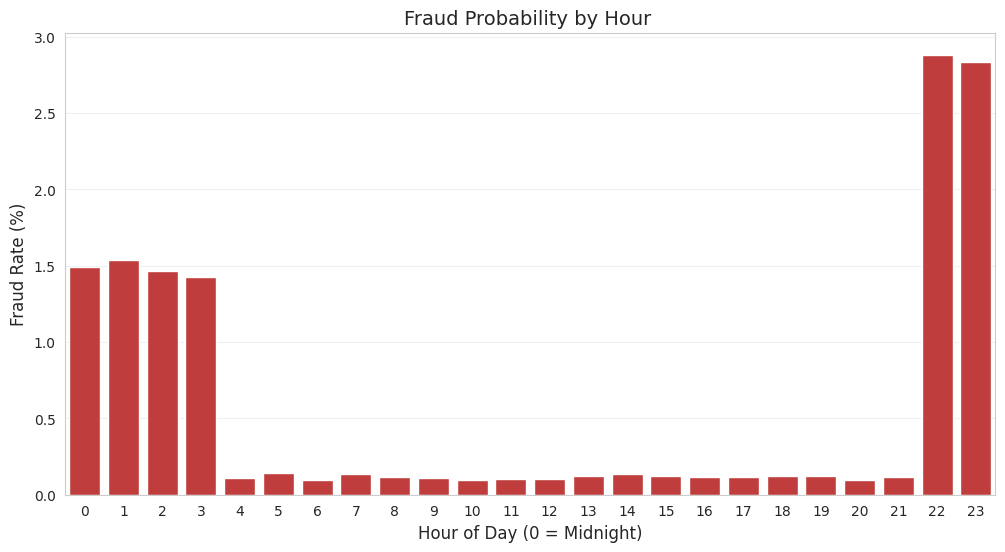

In [21]:
fraud_by_hour = df_refined.groupby('hour')['is_fraud'].mean() * 100

# Creating a Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, color='#d62728')

#  Labels
plt.title('Fraud Probability by Hour ', fontsize=14)
plt.xlabel('Hour of Day (0 = Midnight)', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.show()

3. Where actually the fraudsters are doing the transaction.

*   On x-axis we have all the categories on which purchases have been done.
*   On y-axis we have the Fraud Percentage in that category. A value of "2.5" means "2.5% of all transactions in this category are fake."

/tmp/ipython-input-3012909688.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='magma')


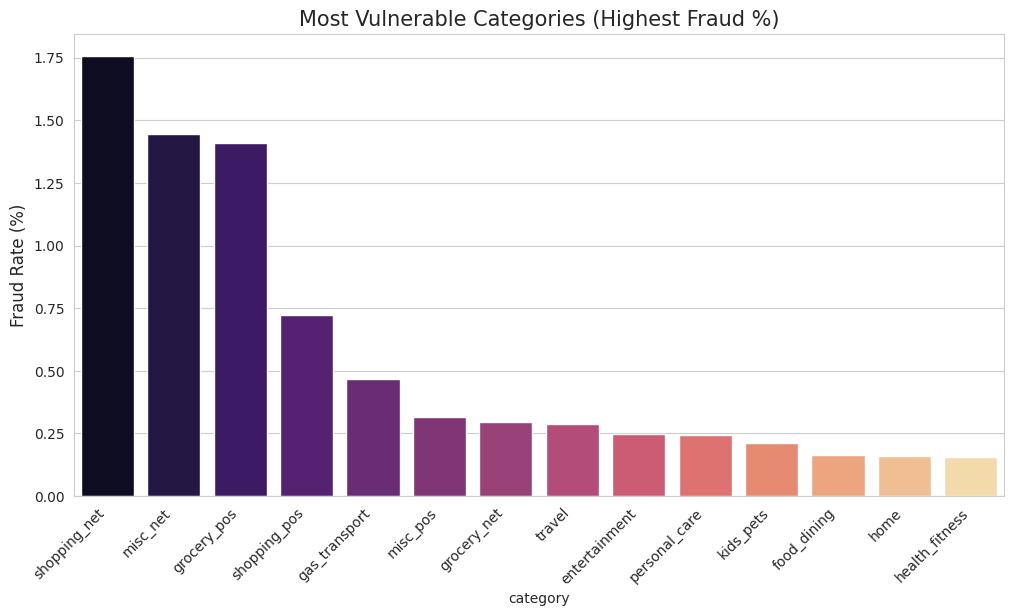

In [22]:
fraud_by_category = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette='magma')

plt.title('Most Vulnerable Categories (Highest Fraud %)', fontsize=15)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

4. To see whether the fraudsters are spending money differently than normal person.

*   on x-axis we have the transaction amount on a log scale. In real life, most transactions are small ($5 coffee), but a few are huge ($2,000 TV). If we used a normal scale, the $5 bars would be huge and the $2,000 bars would be invisible dots. The "Log Scale" squishes the axis so we can see both small and big amounts on the same screen.

*   on y-axis we have the percentage of transaction that fall into that price range.

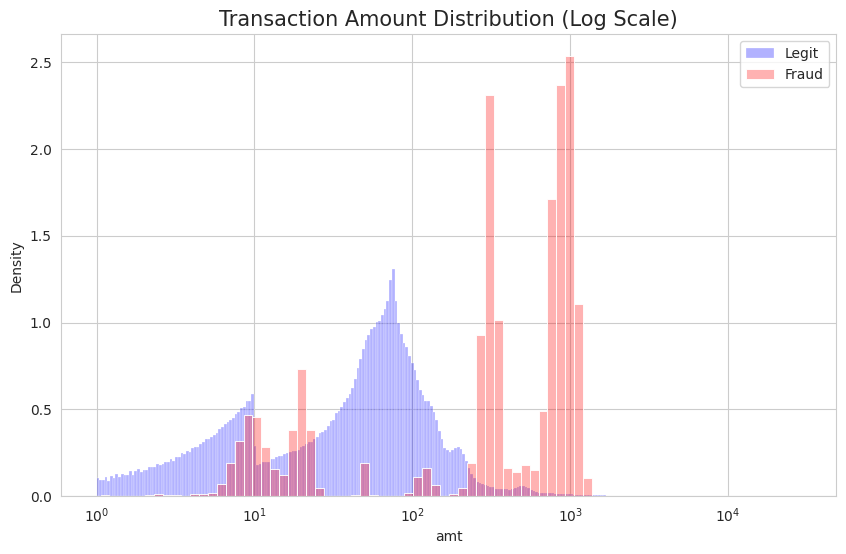

In [23]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df_refined[df_refined['is_fraud']==0], x='amt', color='blue', label='Legit', stat='density', alpha=0.3, log_scale=True)
sns.histplot(data=df_refined[df_refined['is_fraud']==1], x='amt', color='red', label='Fraud', stat='density', alpha=0.3, log_scale=True)

plt.title('Transaction Amount Distribution (Log Scale)', fontsize=15)
plt.legend()
plt.show()

**Feature Encoding**

In [24]:
X_train = df_refined.drop(columns =['is_fraud'])
X_test = df_test_refined.drop(columns = ['is_fraud'])
y_train = df_refined['is_fraud']
y_test = df_test_refined['is_fraud']

In [25]:
print(X_train.shape)
print(X_test.shape)

(1296675, 13)
(555719, 13)


In [26]:
le = LabelEncoder()

for col in ['gender', 'category','pop_type']:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

high_card_cols = ['merchant', 'job']

for col in high_card_cols:
    train_freq = X_train[col].value_counts(normalize=True)
    X_train[col] = X_train[col].map(train_freq)
    X_test[col] = X_test[col].map(train_freq).fillna(0)

In [28]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns,index =X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns,index = X_test.index)

In [33]:
smote = BorderlineSMOTE(
    sampling_strategy=0.4, k_neighbors=5, kind='borderline-1',random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [34]:
print(f"Original Fraud Count: {y_train.sum()}")
print(f"New SMOTE Fraud Count: {y_train_smote.sum()}")

Original Fraud Count: 7506
New SMOTE Fraud Count: 515667


**Model Training**

In [39]:
Dt = DecisionTreeClassifier(max_depth=5,random_state = 42)
Dt.fit(X_train_smote,y_train_smote)
Dt_pred = Dt.predict(X_test_scaled)

In [40]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state = 42)
rf.fit(X_train_smote,y_train_smote)
rf_pred = rf.predict(X_test_scaled)

In [41]:
print(f"Decision Tree Recall: {recall_score(y_test, Dt_pred):.2%}")
print(f"Random Forest Recall: {recall_score(y_test, rf_pred):.2%}")

Decision Tree Recall: 80.28%
Random Forest Recall: 79.21%


In [42]:
print(f"Decision Tree Accuracy: {accuracy_score(y_test, Dt_pred):.2%}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.2%}")

Decision Tree Accuracy: 98.68%
Random Forest Accuracy: 98.23%


In [43]:
print(f"Decision Tree precision: {precision_score(y_test, Dt_pred):.2%}")
print(f"Random Forest precision: {precision_score(y_test, rf_pred):.2%}")

Decision Tree precision: 19.90%
Random Forest precision: 15.32%


In [44]:
cm_dt = confusion_matrix(y_test, Dt_pred)
cm_rf = confusion_matrix(y_test, rf_pred)

In [45]:
print("Decision Tree confusion matrix")
print(cm_dt)
print("\nrandom forest confusion matrix")
print(cm_rf)

Decision Tree confusion matrix
[[546644   6930]
 [   423   1722]]

random forest confusion matrix
[[544181   9393]
 [   446   1699]]


In [71]:
xgb_model = XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_smote, y_train_smote)

xgb_pred = xgb_model.predict(X_test_scaled)

print(f"Recall :    {recall_score(y_test, xgb_pred):.2%}")
print(f"Precision :      {precision_score(y_test, xgb_pred):.2%}")

cm_xgb = confusion_matrix(y_test, xgb_pred)
print(cm_xgb)

Recall :    78.04%
Precision :      89.95%
[[553387    187]
 [   471   1674]]


In [77]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# 1. Initialize Model with Precision Constraints
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    # --- PRECISION TUNING ---
    max_depth=5,
    num_leaves=20,
    min_child_samples=100,
    reg_alpha=1.0,
    reg_lambda=10.0,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    metric='auc',
    verbosity=-1
)

lgb_model.fit(X_train_smote, y_train_smote)

lgb_pred = lgb_model.predict(X_test_scaled)

print(f"Recall:    {recall_score(y_test, lgb_pred):.2%}")
print(f"Precision: {precision_score(y_test, lgb_pred):.2%}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, lgb_pred))

Recall:    76.92%
Precision: 91.77%

Confusion Matrix:
[[553426    148]
 [   495   1650]]


In [80]:
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, recall_score, precision_score

def find_and_apply_balance(model, model_name, X_test, y_test):
    # 1. Get Probabilities
    y_probs = model.predict_proba(X_test)[:, 1]

    # 2. Calculate Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    # 3. Find the Balance Point (Intersection)
    # We remove the last 1 values of prec/recall because they have one extra element than thresholds
    diff = np.abs(precisions[:-1] - recalls[:-1])
    balance_idx = np.argmin(diff)
    balance_thresh = thresholds[balance_idx]

    # 4. Apply Threshold
    y_pred_balanced = (y_probs >= balance_thresh).astype(int)

    # 5. Print Results
    print(f"\n--- {model_name} Balanced Results ---")
    print(f" Best Threshold:   {balance_thresh:.4f}")
    print(f" Precision:        {precisions[balance_idx]:.2%}")
    print(f" Recall:           {recalls[balance_idx]:.2%}")

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_balanced))

    return balance_thresh, precisions[balance_idx], recalls[balance_idx]

# --- RUN FOR XGBOOST ---
xgb_thresh, xgb_prec, xgb_rec = find_and_apply_balance(xgb_model, "XGBoost", X_test_scaled, y_test)

# --- RUN FOR LIGHTGBM ---
lgb_thresh, lgb_prec, lgb_rec = find_and_apply_balance(lgb_model, "LightGBM", X_test_scaled, y_test)




--- XGBoost Balanced Results ---
 Best Threshold:   0.2861
 Precision:        82.19%
 Recall:           82.19%
Confusion Matrix:
[[553192    382]
 [   382   1763]]

--- LightGBM Balanced Results ---
 Best Threshold:   0.2581
 Precision:        82.05%
 Recall:           82.05%
Confusion Matrix:
[[553189    385]
 [   385   1760]]


In [87]:
final_threshold = 0.32
y_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

y_pred_final = (y_probs >= final_threshold).astype(int)

print(f" Threshold: {final_threshold} ---")
print(classification_report(y_test, y_pred_final))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
print(cm)


 Threshold: 0.32 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.84      0.82      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.92      0.91      0.91    555719
weighted avg       1.00      1.00      1.00    555719

Confusion Matrix:
[[553241    333]
 [   396   1749]]


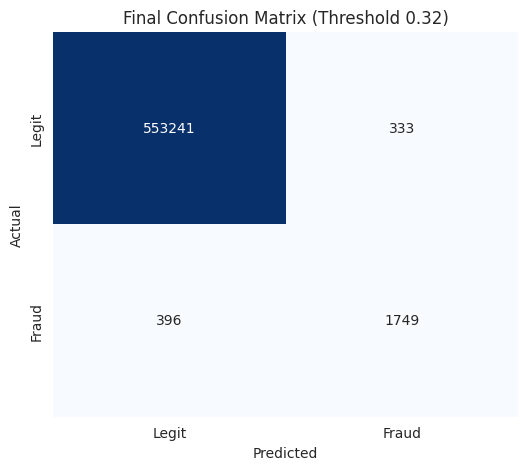

 System saved successfully. Ready for deployment!


In [88]:
import joblib

# 1. Visualize the Final Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Final Confusion Matrix (Threshold {final_threshold})')
plt.show()

# 2. Save the Model & Threshold for future use
final_package = {
    'model': xgb_model,
    'threshold': 0.32,
    'scaler': scaler
}

joblib.dump(final_package, 'fraud_detection_system.pkl')
print(" System saved successfully. Ready for deployment!")